# Codebase for "A Dynamic Theory of Deterrence and Compliance"

Format: JupyterLab Notebook

Kernel: Python3

Code for all results and figures. 

*Note, to use this file user must first set the local path to store results of computation.*

In [5]:
""" 
    import libraries and set display options 
"""
import sys
import matplotlib.collections

import random as rn
import numpy as np
import math as math
import quantecon as qe
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numba import jit


#path_data = 
#path_code = 
#path_figs = 

In [6]:
""" 
    baseline model parameters for kernel
    
"""
# main parameters
agents = 100
Z = 2

# distribution parameters
ḡ , σ = 0.6 , 0.2

# Bayesian priors
α, β = 1, 0.25

# costs
ρ, λ = 2 , 5

# domain of analysis for policy
F = 1
R_low, R_high = 0, agents+1

# benchmarking parameters
block = 50000
checks, C = 5, 0.01

In [7]:
""" 
    functions used by simulations 
"""
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

# apprehension function, min catch
@jit(nopython=True)
def Apprehend(v, R):
    γ = 0.80 
    if v == 0:
        prob_a = γ
    else:
        prob_a = γ*min(1, R/v)
    return prob_a

# create a distribution of 'criminal opportunities'
@jit(nopython=True)
def Criminal_opps(μ, σ, agents, T):
    g = np.zeros((T,agents))
    for i in range(T):
        g[i] = [max(0, np.random.normal(ḡ, σ)) for agent in range(agents)]
    return g

def Simulation(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t, q_t = [], [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    append_q = q_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a, v, g, q = 0, 0, 0, 0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
        append_q(q)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:]), np.array(q_t[init_period+Z:])

def Dynamic_q(criminal_opps, BE, RGB, RBB, F, Z):
# agent priors
    T = len(criminal_opps)
    α,β = 1, 0.25
    r = RGB
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t, r_t, p_t, q_t = [], [], [], [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    append_r = r_t.append
    append_p = p_t.append
    append_q = q_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = stats.binom.rvs(v, Apprehend(v, r))
        append_v(v)
        append_a(a)
        append_r(r)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        if t > 0:
            if v >= BE:
                r = RBB
            else:
                r = RGB 
        else:
            r = RGB
        a,v,g = 0,0,0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, r))
        append_v(v)
        append_a(a)
        append_g(g)
        append_r(r)
        append_q(q)
        append_p(Apprehend(v, r))
    
    return np.array(v_t[-T:]), np.array(a_t[-T:]), np.array(g_t[-T:]), np.array(r_t[-T:]),np.array(p_t[-T:]),np.array(q_t[-T:])

In [8]:
"""
    Produces a sample time series
        Note: User has to select time slice for visulization
        
"""
# parameters
OCD = [39,60,53]
block = 1000
agents, F, Z = 100, 1, 2
α,β = 1, 0.25

criminal_opps = Criminal_opps(ḡ,σ,agents,block)
v, a, g, r, p, q = Dynamic_q(criminal_opps, OCD[2], OCD[0], OCD[1], F, Z)

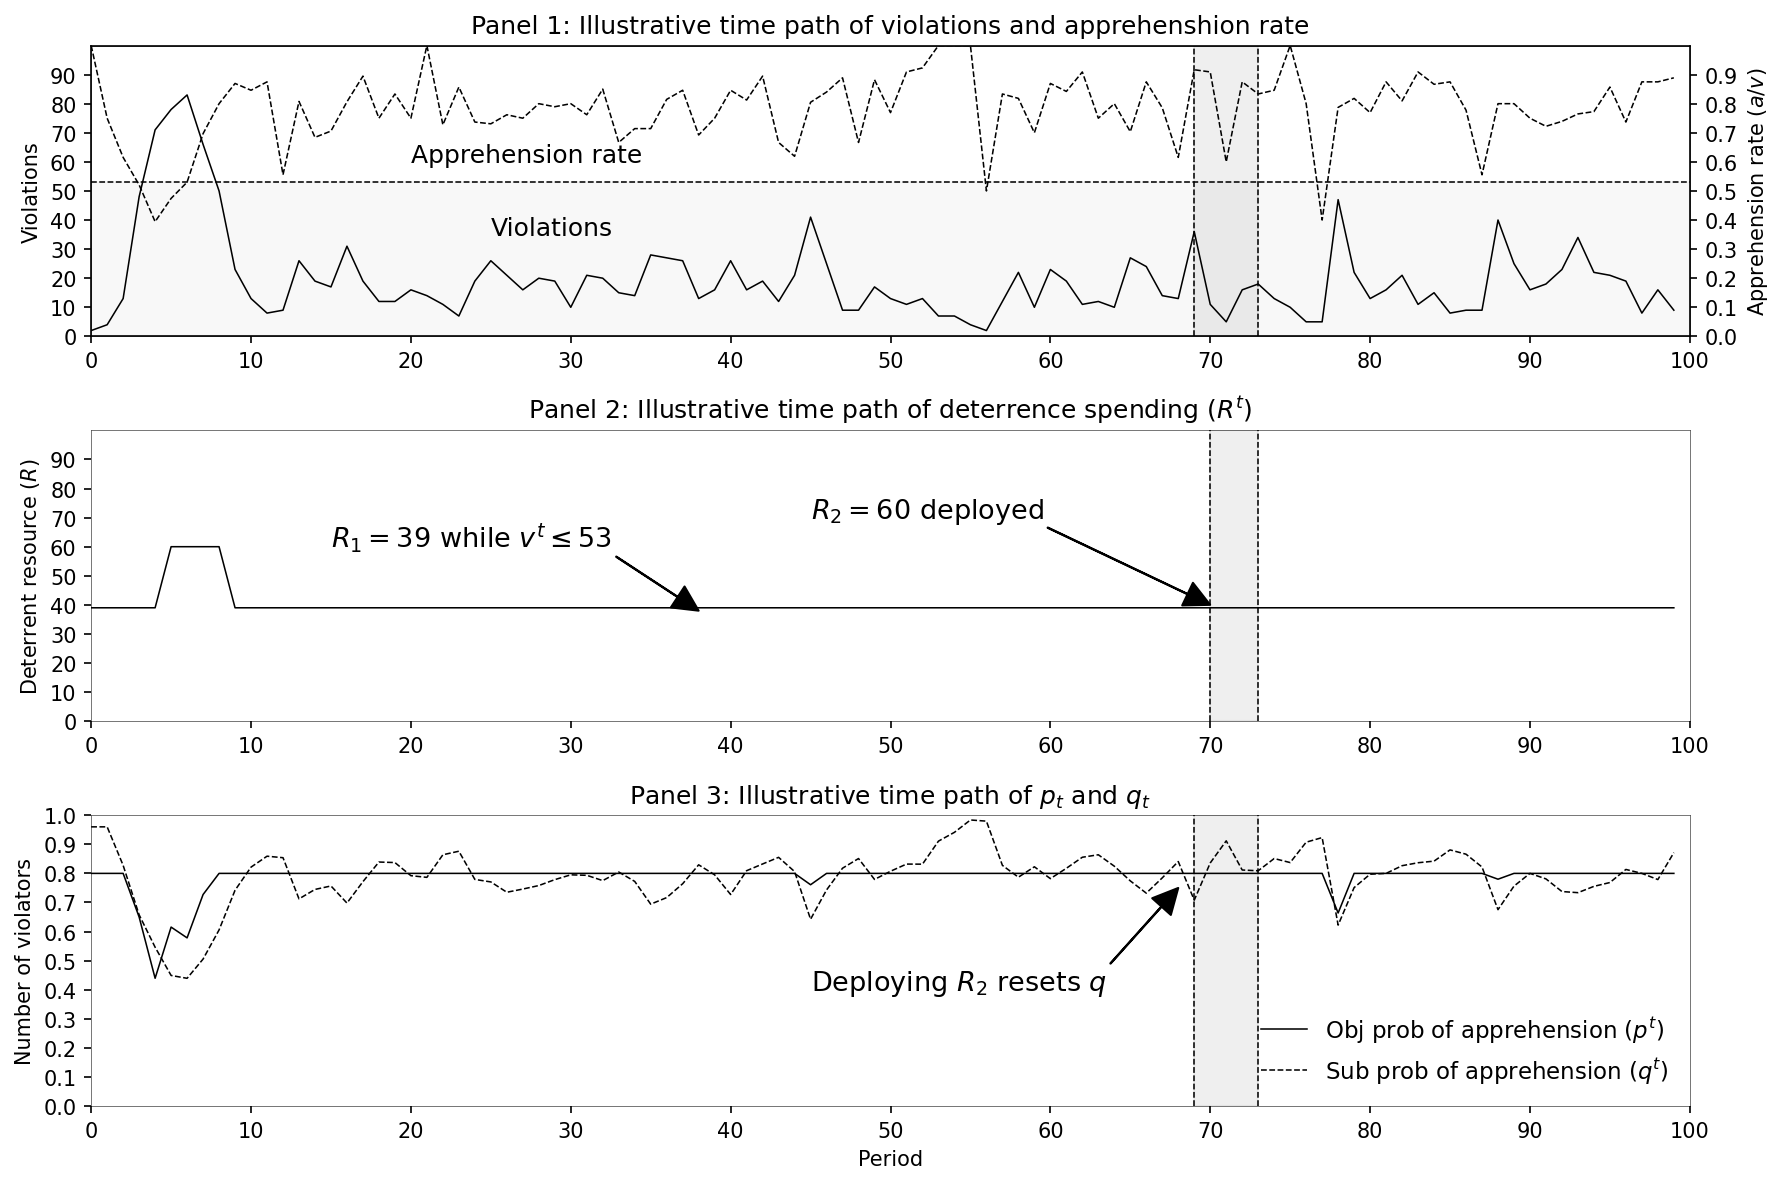

In [10]:
fig = plt.figure(figsize=(12,8),tight_layout=True,dpi=150)   
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

low_slice = 100

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.25)
    ax2.spines[axis].set_linewidth(0.25)
    ax3.spines[axis].set_linewidth(0.25)

ax1.set_title('Panel 1: Illustrative time path of violations and apprehenshion rate')
ax1.set(ylabel='Violations')
ax1i = ax1.twinx()
ax1.set_xticks(np.arange(0,110, 10))
ax1.set_yticks(np.arange(0,agents, 10))
ax1.set_xlim([0, 100])
ax1.set_ylim([0, agents])
ax1.plot(v[low_slice:low_slice+100], color='k', linestyle='solid',linewidth=0.75)
ax1i.plot(a[low_slice:low_slice+100]/v[low_slice:low_slice+100], color ='k', linestyle='dashed',linewidth=0.75)
ax1.hlines(53, xmin=0, xmax=100, linestyle='dashed', color ='k', linewidth=0.75) 
ax1.vlines(69, ymin=0, ymax=agents, linestyle='dashed', color ='k', linewidth=0.75) 
ax1.vlines(73, ymin=0, ymax=agents, linestyle='dashed', color ='k', linewidth=0.75)
ax1.axhspan(0, 53, alpha=0.10, color='silver')
ax1.axvspan(69, 73, alpha=0.25, color='silver')
ax1.text(25,35,'Violations',color='k',fontsize='12')
ax1.text(20,60,'Apprehension rate',color='k',fontsize='12')
ax1i.set(ylabel='Apprehension rate ($a/v$)')
ax1i.set_xticks(np.arange(0,110, 10))
ax1i.set_yticks(np.arange(0, 1, 0.1))
ax1i.set_xlim([0, 100])
ax1i.set_ylim([0, 1])


ax2.set_title('Panel 2: Illustrative time path of deterrence spending ($R^t$)')
ax2.set(ylabel='Deterrent resource ($R$)')
ax2.set_xticks(np.arange(0,110, 10))
ax2.set_yticks(np.arange(0,agents, 10))
ax2.set_xlim([0, 100])
ax2.set_ylim([0, agents])
ax2.plot(r[low_slice:low_slice+100], color ='k', linestyle='solid',linewidth=0.75, 
            label = 'R history')
ax2.vlines(70, ymin=0, ymax=agents, linestyle='dashed', color ='k', linewidth=0.75) 
ax2.vlines(73, ymin=0, ymax=agents, linestyle='dashed', color ='k', linewidth=0.75)
ax2.axvspan(70, 73, alpha=0.25, color='silver')
ax2.annotate('$R_2=60$ deployed', xy=(70, 40), xytext=(45, 70), fontsize=13,
            arrowprops=dict(facecolor='black', shrink=0.0005, width=0.15))
ax2.annotate('$R_1=39$ while $v^t\leq 53$', xy=(38, 38), xytext=(15, 60), fontsize=13,
            arrowprops=dict(facecolor='black', shrink=0.0005, width=0.15))

ax3.set_title('Panel 3: Illustrative time path of $p_t$ and $q_t$')
ax3.set(ylabel='Number of violators')
ax3.set(xlabel='Period')
ax3.set_xticks(np.arange(0,110, 10))
ax3.set_yticks(np.arange(0,1.1, 0.1))
ax3.set_xlim([0, 100])
ax3.set_ylim([0, 1])
ax3.plot(p[low_slice:low_slice+100], color='k', linestyle='solid',linewidth=0.75, label='Obj prob of apprehension ($p^t$)')
ax3.plot(q[low_slice:low_slice+100], color='k', linestyle='dashed',linewidth=0.75, label='Sub prob of apprehension ($q^t$)')
ax3.vlines(69, ymin=0, ymax=agents, linestyle='dashed', color='k', linewidth=0.75) 
ax3.vlines(73, ymin=0, ymax=agents, linestyle='dashed', color='k', linewidth=0.75)
ax3.axvspan(69, 73, alpha=0.25, color='silver')
ax3.annotate('Deploying $R_2$ resets $q$', xy=(68, 0.75), xytext=(45, 0.4), fontsize=13,
            arrowprops=dict(facecolor='black', shrink=0.0005, width=0.15))
ax3.legend(loc='lower right', fontsize=11, frameon=False)

#plt.savefig();